In [183]:
import json
import pandas as pd
import matplotlib as plt

# Step 1: Load the JSONL file containing movie data
with open('data/content.jsonl', 'r') as f:
    movies_data = [json.loads(line) for line in f]

# Step 2: Load the CSV file containing user ratings
df = pd.read_csv('submissoes/lightfm_versao_2_puro.csv')
# Normalize the Rating column
#df["Rating"] = df["Rating"].apply(lambda x: min(x, 10))
print(df.head())

# Step 3: Create a dictionary of imdbRatings from the movies data
imdbRatings = {movie['ItemId']: movie['imdbRating'] for movie in movies_data}
metascore = {movie['ItemId']: movie['Metascore'] for movie in movies_data}
imdbVotes = {movie['ItemId']: movie['imdbVotes'] for movie in movies_data}
boxOffice = {}

for movie in movies_data:
    item_id = movie['ItemId']
    box_office = movie.get('BoxOffice', 'N/A')
    if box_office == 'N/A':
        box_office = 0  # Replace 'N/A' with 0
    else:
        # Remove any non-numeric characters like "$" and commas, then convert to an integer
        box_office = int(''.join(c for c in box_office if c.isdigit()))
    boxOffice[item_id] = box_office


       UserId      ItemId    Rating
0  0006246bee  80d1dae630  0.020822
1  0006246bee  899610035b -2.372907
2  0006246bee  aad36aac60 -2.551281
3  0006246bee  c1ee6829f5 -2.712074
4  0006246bee  ade4907055 -3.027950


In [184]:
imdbRatings

{'c9f0f895fb': '5.5',
 'd3d9446802': '6.9',
 'c20ad4d76f': '7.5',
 '8e296a067a': '4.2',
 '54229abfcf': '6.7',
 '1afa34a7f9': '5.8',
 '41ae36ecb9': '8.2',
 'eed5af6add': '7.3',
 '13f3cf8c53': 'N/A',
 '42e77b6363': '5.7',
 '013a006f03': '6.4',
 '43cca4b3de': '6.4',
 '54f5f4071f': '6.5',
 'c5866e93ca': '5.1',
 'f15d337c70': '7.0',
 'd254c8a084': '6.3',
 '6f1d0705c9': '7.0',
 '33ef701c80': '7.1',
 'c4d2ce3f3e': '6.0',
 '68897f19b1': '5.2',
 'a3ec6dd8d5': '6.0',
 '6abcc8f243': '6.0',
 'ef35613fc5': '5.7',
 'f016f25df0': '6.1',
 'aa36c88c27': '6.4',
 '70afbf2259': '5.5',
 '597c7b407a': '5.0',
 '09def3ebbc': '6.3',
 '64a7157cf3': '6.7',
 'e32c51ad39': '6.2',
 'e1cd50f4a9': '6.8',
 'e1054bf2d7': '6.6',
 '412604be30': 'N/A',
 '3366297a63': '6.0',
 '233f1dd0f3': '6.9',
 'd98c1545b7': '7.0',
 '1b84c4cee2': '7.3',
 'e562cd9c07': '6.2',
 '1ee942c6b1': '7.0',
 '498f2c2168': '7.3',
 '55479c55eb': '6.5',
 '324545ee1d': '6.6',
 '77ef24b42f': '7.7',
 'f6b6d2a114': '7.1',
 '7dd3ed2e12': '7.1',
 '89c86ad4

<Axes: >

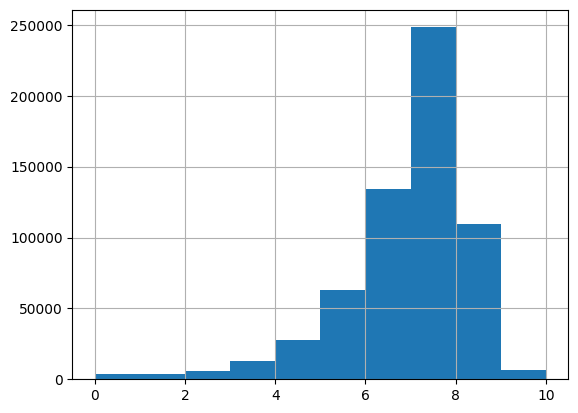

In [185]:
df["Rating"] = df["Rating"].apply(lambda x: max(x, -20))
df['Rating'] = (df['Rating'] - df['Rating'].min()) / (df['Rating'].max() - df['Rating'].min()) * 10
df['Rating'].hist()

<Axes: >

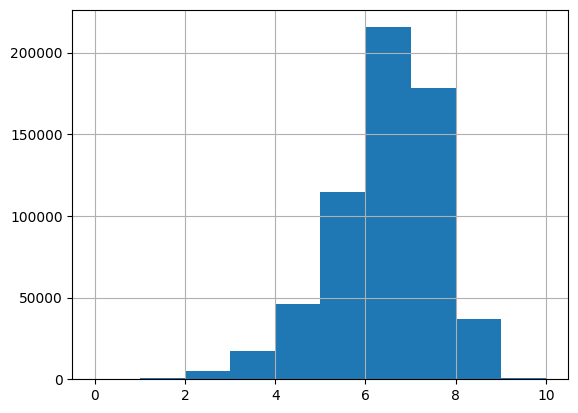

In [186]:
df['imdbRating'] = df['ItemId'].map(imdbRatings)
df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors='coerce')
df["imdbRating"] = df["imdbRating"].fillna(df['Rating'])
df["imdbRating"].hist()

In [187]:
df['BoxOffice'] = df['ItemId'].map(boxOffice)
df["BoxOffice"] = df["BoxOffice"].replace({"$": "", ",": ""}, regex=True)
df["BoxOffice"] = pd.to_numeric(df["BoxOffice"], errors='coerce')
min_box_office = df['BoxOffice'].min()
max_box_office = df['BoxOffice'].max()
df['BoxOffice'] = (df['BoxOffice'] - min_box_office) / (max_box_office - min_box_office) * 10

In [188]:
df['Metascore'] = df['ItemId'].map(metascore)
df["Metascore"] = pd.to_numeric(df["Metascore"], errors='coerce')
df["Metascore"] = df["Metascore"]/10
df["Metascore"] = df["Metascore"].fillna(df['imdbRating'])

In [189]:
df['imdbVotes'] = df['ItemId'].map(imdbVotes)
df["imdbVotes"] = pd.to_numeric(df["imdbVotes"], errors='coerce')
df["imdbVotes"] = df["imdbVotes"]/100

<Axes: >

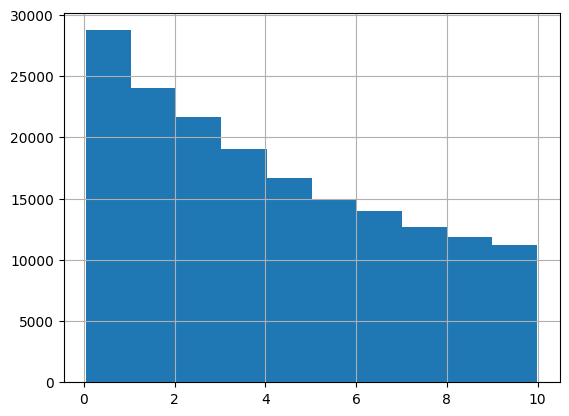

In [190]:
df["imdbVotes"].hist()

In [191]:
df['Score'] = (
    0.3 * df["imdbRating"] +
    2 * df["BoxOffice"] +
    0.2 * df["Metascore"] +
    0.2 * df["Rating"] + 
    0.1 * df["imdbVotes"]
)
df['Score'] = df['Score'].fillna(0.3 * df["imdbRating"] + 2 * df["BoxOffice"] + 0.25 * df["Metascore"] + 0.25 * df["Rating"])

<Axes: >

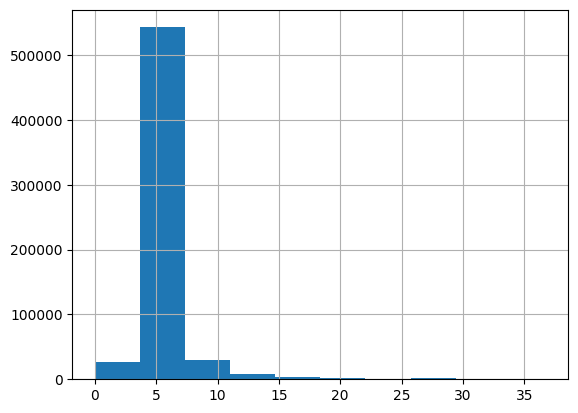

In [192]:
df['Score'].hist()

In [193]:
df = df.sort_values(['UserId', 'Score'], ascending=[True, False])

In [194]:
df

,UserId,ItemId,Rating,imdbRating,BoxOffice,Metascore,imdbVotes,Score
80,0006246bee,ce297c0305,6.561498,6.6,5.500409,5.3,NaN,21.446602
83,0006246bee,9277d31cc9,6.500666,6.9,4.318955,5.8,NaN,18.102031
91,0006246bee,b273133e05,6.400281,7.9,1.765452,8.2,NaN,11.316427
13,0006246bee,1e5bdbcb76,7.149924,8.1,0.582000,8.8,NaN,8.163481
3,0006246bee,c1ee6829f5,7.762975,8.0,0.713274,5.8,NaN,7.930566
...,...,...,...,...,...,...,...,...
616130,fffffe98d0,fca8263961,3.857360,3.3,0.000000,3.3,4.28,2.849472
616153,fffffe98d0,6df45274cf,3.583681,3.8,0.000000,3.8,2.16,2.832736
616135,fffffe98d0,e5076931c7,3.834112,4.2,0.002087,1.8,NaN,2.674788
616149,fffffe98d0,aec7adaa71,3.625858,2.6,0.000000,2.6,4.82,2.507172


In [195]:
df = df.drop(columns=['Rating', 'imdbRating', 'Score', 'BoxOffice', 'Metascore', 'imdbVotes'])
df.to_csv('alexperimento17.csv', index=False)